# Open data on broadband in Egypt

In this notebook, we map employ different open data sources to get an overview of the broadband access for some schools in Egypt. 

Throughout the notebook we use:

- The borders of Egypt by [GADM](https://gadm.org/).
- Open data sets by [HOTOSM](https://data.humdata.org/dataset/hotosm_egy_education_facilities), on education facilities in Egypt.
- The broadmap maps [by ITU](https://bbmaps.itu.int/bbmaps/), which provide an overview over fiber networks all over the world.
- The open dataset from [Ookla](https://www.ookla.com/ookla-for-good/open-data), which provides maps of download speeds.

All the plots and data analysis is done with two `python` packages:

- [geopandas](https://geopandas.org/en/stable/), which is designed for the work with geospatial data in python.
- [matplotlib](https://matplotlib.org/), which is the standard python library for plotting.
- [requests](https://requests.readthedocs.io/en/latest/), which allows us to directly connect with webservers.


In the next steps of the tutorial, we will:

- Discuss how to import the different datasets
- Connect them.
- Plot them up.

## Python dependencies

Before we can get started, we should make sure that the python packages are available. If the next field cannot be executed, you should install them via a pip install

```
pip install geopandas
pip install matplotlib
pip install requests
```


In [1]:
import geopandas as gp
import matplotlib.pyplot as plt
import requests

%matplotlib inline

## The country borders

In this first step, we will obtain the borders of the country and then plot them. 

- To get the data, we go onto the [website](https://gadm.org/download_country.html) of GADM and then decide to download the *Shapefile*. Other formats are possible, but do not really change the outcome here.
- We save the downloaded file at the same position as this notebook under the name `gadm41_EGY_shp.zip`.
- We can now read the file and plot it up by executing the cell below.

After executing the cell, we can access the data from the object `egypt_map`.


<Axes: >

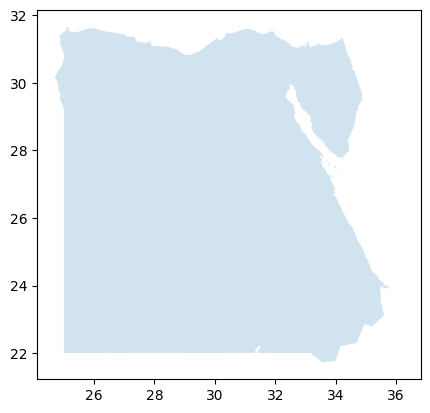

In [3]:
egypt_map = gp.read_file("data/gadm41_EGY_shp.zip")
egypt_map.plot(color="C0", alpha=0.2)

## Education facilities

In this step, we will now import the position of the education facilities:

- We download them from [this website](https://data.humdata.org/dataset/hotosm_egy_education_facilities). Once again we choose the *Shapefile* for simplicity.
- We safe the file in the same folder as this notebook.
- We can now plot the position of the education facilities on the country borders.

In the following, the education facilities are accessible through the variable name `education_map`. 

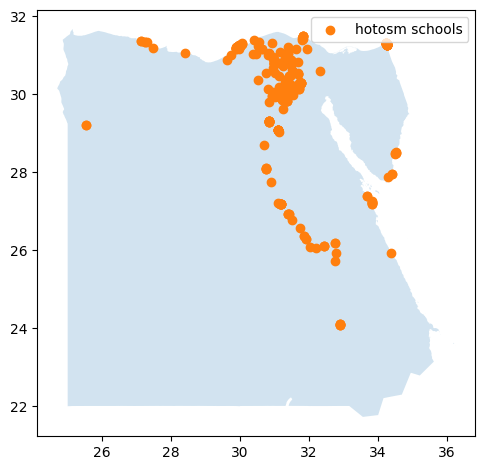

In [4]:
education_map = gp.read_file("data/hotosm_egy_education_facilities_points_shp.zip")

fig, ax1 = plt.subplots()

egypt_map.plot(ax=ax1, color="C0", alpha=0.2)
education_map.plot(ax=ax1, color="C1", label="hotosm schools")
ax1.legend()
fig.tight_layout()

## Fiber network

In the next step, we can download the fiber data for egypt from ITU. We do this through the following code snippet, which should result in you having saved the data in the file `trx_public_geonetwork.geojson`


In [5]:
# URL of the WFS service
url = "https://bbmaps.itu.int/geoserver/ITU/ows"

# Parameters for the GetFeature request
params = {
    "service": "WFS",
    "version": "1.0.0",
    "request": "GetFeature",
    "typeName": "ITU:trx_public_geonetwork",
    "outputFormat": "application/json",
}

# Send the request and download the layer
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Save the GeoJSON to a file
    with open("data/trx_public_geonetwork.geojson", "w") as file:
        file.write(response.text)
    print("Layer downloaded successfully.")
else:
    print("Failed to download the layer:", response.status_code)

Layer downloaded successfully.


Now that we downloaded the code, we can proceed very much like in the last steps. We import the dataset and plot it up. You can see that the fact that we are import a ``GeoJSON` simply means, that we have to specify the driver. Afterwards we can use the object in exactly the same fashion as the other python objects that we imported above.

<Axes: >

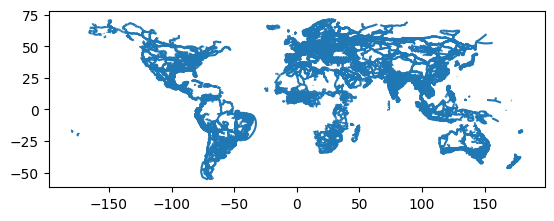

In [6]:
global_fiber = gp.read_file("data/trx_public_geonetwork.geojson", driver="GeoJSON")

global_fiber.plot()

We can see that these data are available worldwide. However, in this notebook we explicitly focus on Egypt. We can filter the data through the function `sjoin`. It looks for spatial overlap of two dataframes, as explained in more detail [here](https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html).

In [7]:
fiber_in_egypt = gp.sjoin(global_fiber, egypt_map, how="inner", predicate="intersects")

We can now take the three data sets together to see which education facilities are within the reach of fiber networks.

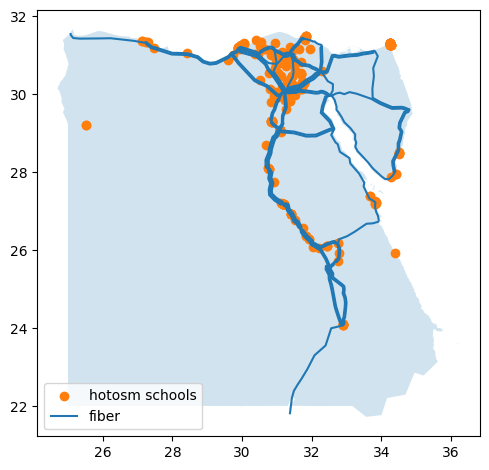

In [8]:
fig, ax1 = plt.subplots()

egypt_map.plot(ax=ax1, color="C0", alpha=0.2)
education_map.plot(ax=ax1, color="C1", label="hotosm schools")
fiber_in_egypt.plot(ax=ax1, color="C0", label="fiber")
ax1.legend()
fig.tight_layout()

## Comparing to download speeds

In the last step, we will superpose the different geospatial informations with measured download speeds. Those download speeds are available on a worldwide scale by [Ookla](https://www.ookla.com/ookla-for-good/open-data). Given that this is a fairly large dataset, we have already cut it down to the region of Egypt. But we explain, how to get it in the last part of this notebook.

At this stage, we already know the workflow. We simply import the file (in this case a `geojson`)

In [9]:
ookla_in_egypt = gp.read_file("data/ookla_in_egypt.geojson", driver="GeoJSON")

And after we imported it, we can have an overview over all of Egypt.

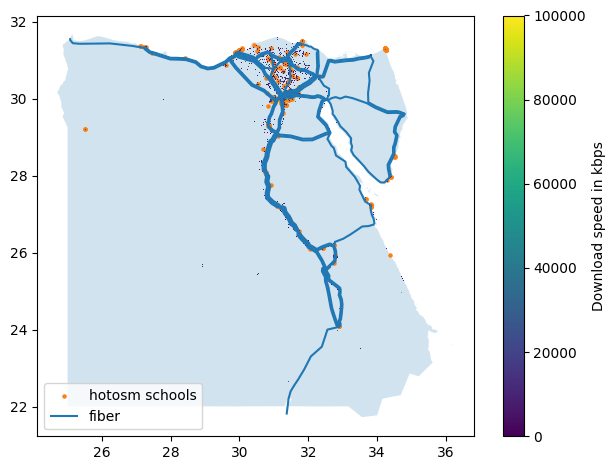

In [10]:
fig, ax1 = plt.subplots()

egypt_map.plot(ax=ax1, color="C0", alpha=0.2)
education_map.plot(ax=ax1, color="C1", label="hotosm schools", markersize=5)
ookla_in_egypt.plot(
    column="avg_d_kbps",
    ax=ax1,
    legend=True,
    legend_kwds={"label": "Download speed in kbps", "orientation": "vertical"},
    vmin=0,
    vmax=1e5,
)
fiber_in_egypt.plot(ax=ax1, color="C0", label="fiber")
ax1.legend()
fig.tight_layout()

Given the size and concentration of Egypt we can also zoom in a bit to see more details.

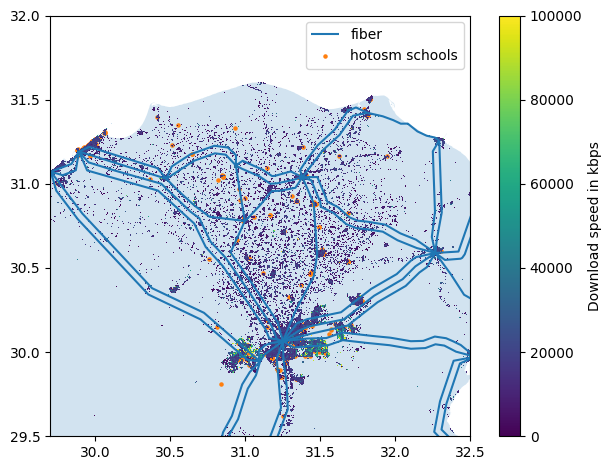

In [11]:
fig, ax1 = plt.subplots()

fiber_in_egypt.plot(ax=ax1, color="C0", label="fiber")
egypt_map.plot(ax=ax1, color="C0", alpha=0.2)
education_map.plot(ax=ax1, color="C1", label="hotosm schools", markersize=5)
ookla_in_egypt.plot(
    column="avg_d_kbps",
    ax=ax1,
    legend=True,
    legend_kwds={"label": "Download speed in kbps", "orientation": "vertical"},
    vmin=0,
    vmax=1e5,
)

ax1.set_xlim(29.7, 32.5)
ax1.set_ylim(29.5, 32)
ax1.legend()
fig.tight_layout()

## Summary

In this tutorial, we have leveraged different open data sources to get an overview for internet access for education facilities in Egypt. We have downloaded different datasets, imported them into python and provided a graphical overlay of the different information.

This can be used as a baseline of different situations, but before we provide you with our ideas, we would be curious to know how you would like to use them.

## Optional: Ookla export

In this section, we import the full dataset. However, this can easily take half an hour. So be warned before you get started. Our first task is to download the dataset itself. The simplest approach is to follow the instructions of the github [here](https://github.com/teamookla/ookla-open-data).
Otherwise, you might simply use this [download link](https://ookla-open-data.s3.amazonaws.com/shapefiles/performance/type=fixed/year=2022/quarter=1/2022-07-01_performance_fixed_tiles.zip). As you might see the dataset is a few hundred MB large.

Once it is download, we can import it into python (this can easily take 20minutes).

In [11]:
ookla_tiles_ww = gp.read_file("2022-07-01_performance_fixed_tiles.zip")

Once, we have imported the whole dataset, we simply select the part that is within Egypt through `sjoin`.

In [12]:
ookla_in_egypt = gp.sjoin(
    ookla_tiles_ww, egypt_map, how="inner", predicate="intersects"
)

And finally we save it appropiately to the file that we have used within the tutorial above.

In [16]:
ookla_in_egypt.to_file("data/ookla_in_egypt.geojson", driver="GeoJSON")